<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/decode_behavior_from_neural_activity_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding behavior from neural activity

Adapted from KordingLab

### Outline
1. Test simulated data
2. Crossvalidation
3. Apply linear regression, logistic regression
4. Apply RNNs
5. Compare DNNs

## Preliminaries

Import modules and simulate data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn

import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# simulate some data

In [ ]:
# Generate some fake trial data
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

# And generate some fake neural recordings
# We'll pretend we have a drift diffusion model

def generate_neural_data(n_trials, n_neurons = 25, n_bins_per_trial = 50,
                         noise_variance = 1, drift_rate = 0.07,
                         mean_rate = 25):
  """Generates fake neural data of shape (n_trials, n_neurons, n_bins_per_trial
        according to a drift diffusion process with given parameters.
     Also generates decisions, which is 0 or 1 depending on the "animal's decision"
        and is returned as an array of shape (n_trials,) 
        
    Returns: (neural_data, decisions)
  """

  decisions = np.random.binomial(1,.5,size = n_trials)
  
  neural_recordings = np.zeros((n_trials,n_neurons,n_bins_per_trial))

  for t in range(n_bins_per_trial):
    if t==0:
      neural_recordings[:,:,t] = mean_rate + np.random.randn(n_trials,n_neurons) * noise_variance
    else:
      neural_recordings[:,:,t] = neural_recordings[:,:,t-1] \
                      + np.reshape(drift_rate*(decisions*2-1),(len(decisions),1)) \
                      + np.random.randn(n_trials,n_neurons) * noise_variance
      
  return neural_recordings, decisions

neural_recordings, decisions = generate_neural_data(n_trials, 
                                         n_neurons, n_bins_per_trial)

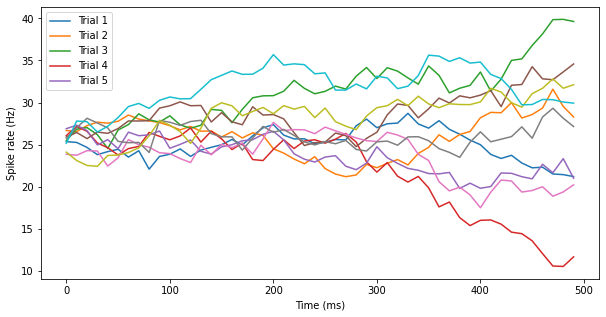

In [ ]:
# plot out some trials for one neuron
neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

## initial models 

In [ ]:
from sklearn import linear_model

In [ ]:
# predict each decision using all neurons's activity throughout the trials

# linear regression
X = np.reshape(neural_recordings, (n_trials,-1))
my_naive_model = linear_model.LinearRegression()

# fit
my_naive_model.fit(X, decisions)

#score
print("R2 was", my_naive_model.score(X,decisions))

R2 was 1.0


In [ ]:
# electrophysiology data
new_neural_recordings, new_decisions = generate_neural_data(n_trials, 
                                             n_neurons, n_bins_per_trial)
new_X = np.reshape(new_neural_recordings, (n_trials,-1))

# score
print("R2 was",my_naive_model.score(new_X,new_decisions))

R2 was 0.2049596956675256


In [ ]:
# initalize logistic regression model
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)
# fit
log_reg.fit(new_X, new_decisions)

# score
print("R2 was",log_reg.score(new_X,new_decisions))

R2 was 1.0


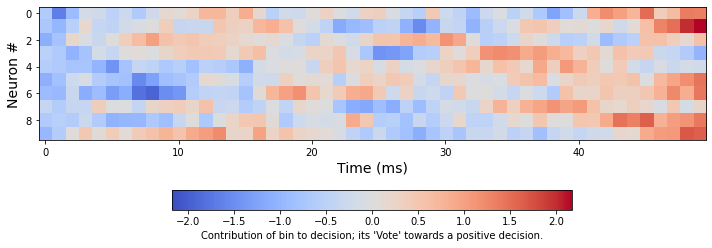

In [ ]:
def plot_coefs(fit_model):
  """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
  # get the coefficients of your fit
  coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)

  # show them
  plt.figure(figsize = (10,5))
  plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients), 
                                              vmax = np.max(coefficients))

  #make it pretty
  plt.ylabel("Neuron #", fontsize = 14)
  plt.xlabel("Time (ms)", fontsize = 14)
  plt.colorbar(orientation = 'horizontal', shrink = .6, 
               label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
  plt.tight_layout()
  plt.show()
  
plot_coefs(log_reg)

Crossvalidation

In [ ]:
split = int(n_trials*4/5)

In [ ]:
idxtrain = random.sample(range(0, n_trials), split)
idxval = np.setdiff1d(range(0, n_trials), idxtrain)
print(idxtrain)
print('\n')
print(idxval)

[204, 70, 228, 179, 219, 210, 92, 192, 181, 33, 34, 144, 173, 213, 191, 54, 20, 40, 196, 223, 105, 201, 22, 18, 117, 4, 109, 149, 231, 14, 246, 222, 91, 237, 88, 230, 225, 167, 76, 140, 205, 74, 142, 182, 84, 129, 163, 195, 90, 161, 146, 97, 56, 138, 208, 247, 104, 8, 99, 239, 87, 183, 121, 131, 36, 27, 46, 158, 127, 187, 15, 216, 63, 198, 135, 137, 13, 26, 52, 96, 44, 193, 242, 197, 66, 23, 83, 43, 16, 89, 212, 17, 116, 132, 115, 80, 202, 248, 175, 249, 110, 227, 156, 169, 7, 79, 111, 65, 1, 72, 113, 168, 133, 2, 102, 3, 6, 100, 62, 128, 5, 224, 194, 160, 82, 172, 145, 58, 12, 155, 209, 184, 125, 47, 94, 171, 114, 57, 241, 232, 126, 71, 186, 42, 122, 75, 234, 226, 211, 206, 185, 103, 233, 49, 119, 25, 162, 101, 120, 31, 235, 189, 174, 60, 134, 51, 68, 229, 200, 45, 10, 170, 178, 136, 78, 177, 188, 108, 81, 154, 236, 64, 29, 139, 30, 95, 77, 141, 218, 61, 48, 69, 32, 41, 21, 53, 217, 28, 112, 199]


[  0   9  11  19  24  35  37  38  39  50  55  59  67  73  85  86  93  98
 106 107 118 1

In [ ]:
training_data = new_neural_recordings[idxtrain,:,:]
validation_data = new_neural_recordings[idxval,:,:]

training_decisions = new_decisions[idxtrain]
validation_decisions = new_decisions[idxval]

new_X_cv = np.reshape(training_data, (split,-1))

In [ ]:
training_data[1:2,:]

array([[[24.37651504, 26.41872067, 27.06264871, 28.5133698 ,
         27.48188651, 26.10600396, 26.95020066, 27.65423256,
         28.79460605, 26.21568422, 27.30933472, 27.16783298,
         27.34636123, 25.78905313, 24.88250029, 25.76549262,
         24.90877299, 25.29094069, 25.03009464, 26.4248842 ,
         25.52992989, 25.80378286, 25.35694771, 24.79173883,
         25.40144901, 25.69497092, 23.8753515 , 23.87957097,
         25.25914236, 25.30769383, 23.70521632, 25.02732474,
         26.2628806 , 27.31327599, 26.60798788, 25.42677788,
         25.65263862, 25.99619897, 26.52327752, 25.27540295,
         24.10445517, 24.15516797, 24.19542661, 23.89866045,
         23.90590506, 23.99540483, 23.32780202, 24.19520921,
         23.10820989, 21.57212205],
        [24.75033686, 24.7744393 , 25.4613794 , 25.58368302,
         24.87307236, 25.59848072, 25.75902743, 25.67191371,
         23.15092189, 23.50115381, 23.87016109, 24.36005311,
         25.92849187, 27.47330222, 28.99852645, 2

In [ ]:
# initalize the model
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)
# fit
log_reg.fit(new_X_cv, training_decisions)

# fit and score on training
print("R2 was",log_reg.score(new_X_cv,training_decisions))


R2 was 1.0


In [ ]:
# k-fold CV
def get_test_train_splits(data, decisions, n_folds=5):
  """
  Returns a tuple of matched train sets and validation sets, rotating through the data.
  
  Note that there are scikit-learn functions that do this, too."""
  
  fold_size = len(data)//n_folds
  
  training_sets = [np.roll(data,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_sets = [np.roll(data,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  
  training_Y = [np.roll(decisions,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_Y = [np.roll(decisions,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  

  return (training_sets, training_Y), (val_sets, val_Y)

Fold 0 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.884


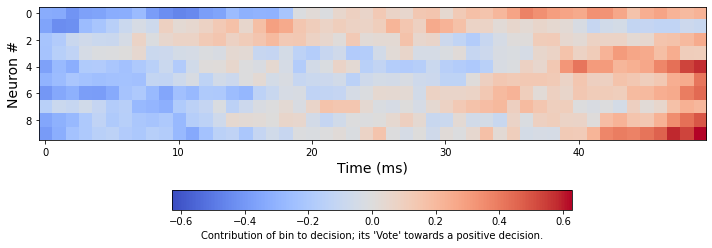

Fold 1 of 5
   Validation accuracy of 0.96
   True test set accuracy of 0.86


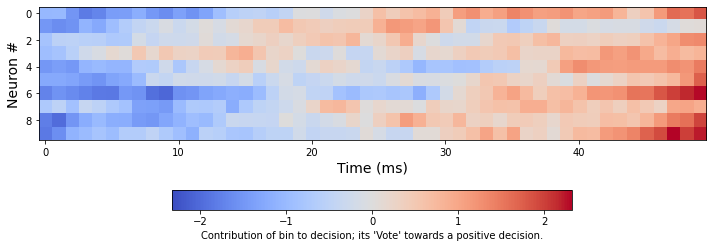

Fold 2 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.88


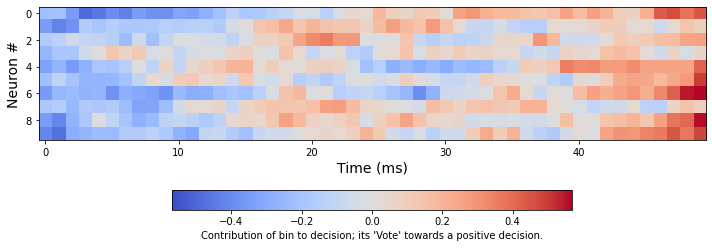

Fold 3 of 5
   Validation accuracy of 0.88
   True test set accuracy of 0.872


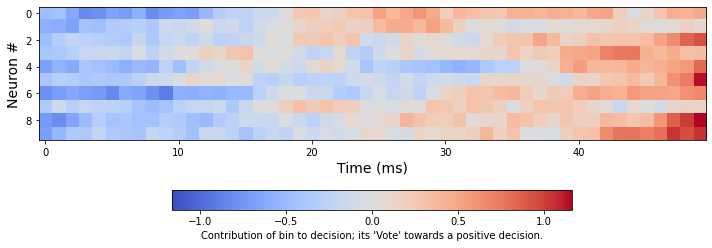

Fold 4 of 5
   Validation accuracy of 0.94
   True test set accuracy of 0.86


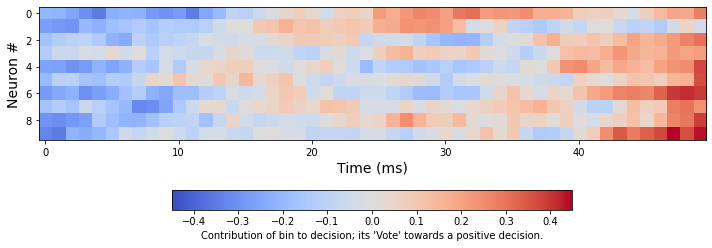

Mean validation accuracy: 0.9199999999999999


In [ ]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_X = training_sets[fold]
  training_Y = training_Ys[fold]
  
  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]
  
  # re-initialize the logistic regression model
  this_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000)
  # fit and score on training
  this_model.fit(training_X, training_Y)
  this_model.score(training_X,training_Y)

  # score on the validation data
  this_accuracy = this_model.score(validation_X,validation_Y)
  scores.append(this_accuracy)
  
  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X,new_decisions)
  
  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

Regularization


Fold 0 of 5
   Validation accuracy of 0.86
   True test set accuracy of 0.876


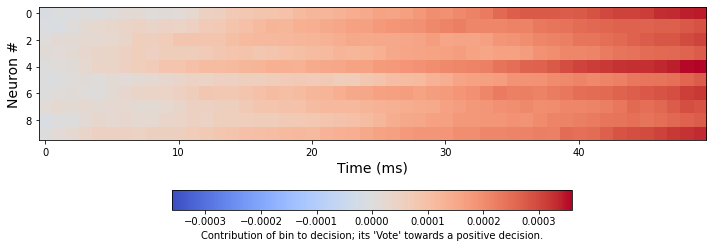

Fold 1 of 5
   Validation accuracy of 0.84
   True test set accuracy of 0.784


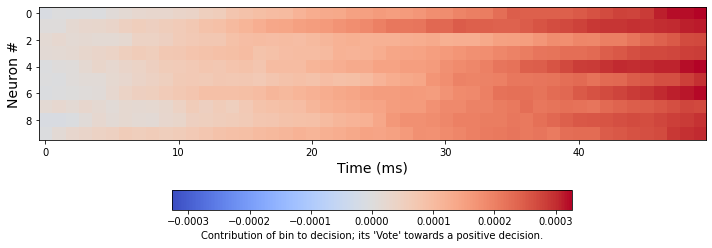

Fold 2 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.888


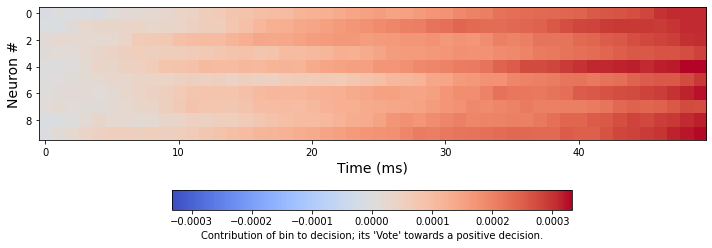

Fold 3 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.884


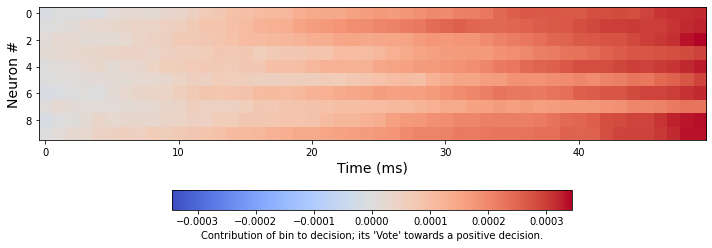

Fold 4 of 5
   Validation accuracy of 0.94
   True test set accuracy of 0.88


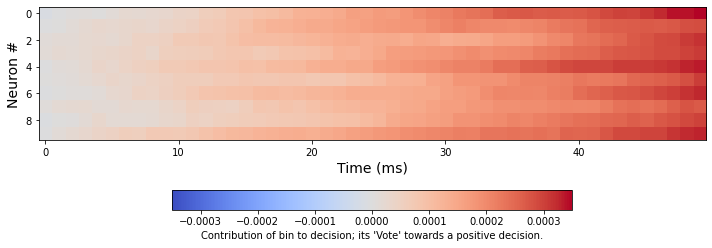

Mean validation accuracy: 0.8879999999999999


In [ ]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                 max_iter = 1000, C=1e-6)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    this_model.score(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)

    print("   Validation accuracy of {}".format( this_accuracy ))
    print("   True test set accuracy of {}".format( accuracy_on_test_data ))
    plot_coefs(this_model)

print("Mean validation accuracy: {}".format(np.mean(scores)))

#### Choose the best regularization penalty, 'C'

In [ ]:
# First complete this function that takes data (e.g. X) 
# and a model, and returns the average validation accuracy from 5-fold CV
# (Largely copy and past from above, but deleting print statements)
def get_kfold_validation_score(data, decisions, C):
  (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(data, decisions)

  scores = []

# Iterate through the k=5 folds
  for fold in range(5):
    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                max_iter = 1000, C=C)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    this_model.score(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)  

    
  
  return np.mean(scores)

test various values of `C` and see what's the best.


In [ ]:
# decide on a logarithmic schedule of Cs. 
Cs_to_test = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = get_kfold_validation_score(X, decisions, C)
  
  validation_accuracy_vs_C.append(mean_validation_accuracy)
  
  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(0.8, 1.0)

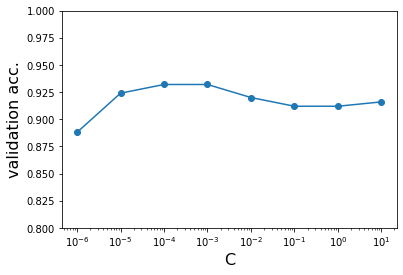

In [ ]:
# plot
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

## Applying recurrent neural networks

In [ ]:
!pip install Neural-Decoding --upgrade

In [ ]:
from Neural_Decoding import decoders

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
?decoders.SimpleRNNClassification

The shape of the training inputs is now **3-dimensional** to model effect of time. n_trials x n_neurons x n_timebins

In [ ]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


Training input data is of shape (200, 50, 10)
Validation input data is of shape (50, 50, 10)


In [ ]:
# instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [ ]:
# fit
my_RNN_classifier.fit(training_data, training_decisions)

In [ ]:
# predict
predictions = my_RNN_classifier.predict(validation_data)
predictions

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1])

In [ ]:
#my_RNN_classifier.score(validation_data, validation_decisions)
accuracy = np.sum(predictions == validation_decisions) / len(predictions)
print(accuracy)


0.88


#### RNN hyperparameter tuning

## Compare many methods on real neural data

### Preliminaries

remember to check GPU runtime

In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


Unzipping...Done.


In [ ]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


### Predicting choices from neural population recordings

Try to predict the mouse's choices from the neuropixel recordings in the 1 second preceeding each choice. `binned_spikes.npy` is a numpy array containing the binned spike rates, and `choices.npy` contains the animal's choices. 

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).





In [ ]:
print(binned_spikes.shape, choices.shape)
print(choices[:10])

(228, 1089, 50) (228,)
[2. 2. 0. 0. 0. 1. 0. 0. 0. 2.]


In [ ]:
# split training and validation data
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [ ]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =10,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Epoch 1/10
6/6 [==============================] - 17s 3s/step - loss: 1.0923 - accuracy: 0.4176
Epoch 2/10
6/6 [==============================] - 10s 2s/step - loss: 0.8934 - accuracy: 0.5714
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.7628 - accuracy: 0.7363
Epoch 4/10
6/6 [==============================] - 6s 977ms/step - loss: 0.6451 - accuracy: 0.7967
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 0.5342 - accuracy: 0.8626
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.4333 - accuracy: 0.9231
Epoch 7/10
6/6 [==============================] - 6s 1s/step - loss: 0.3792 - accuracy: 0.9231
Epoch 8/10
6/6 [==============================] - 6s 1s/step - loss: 0.3091 - accuracy: 0.9615
Epoch 9/10
6/6 [==============================] - 6s 998ms/step - loss: 0.2326 - accuracy: 0.9835
Epoch 10/10
6/6 [==============================] - 6s 1s/step - loss: 0.1749 - accuracy: 0.9890

 validation accuracy: 50.0 %


Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [ ]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 20,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


Epoch 1/20
6/6 [==============================] - 46s 6s/step - loss: 1.0809 - accuracy: 0.4176
Epoch 2/20
6/6 [==============================] - 30s 5s/step - loss: 1.0315 - accuracy: 0.4725
Epoch 3/20
6/6 [==============================] - 30s 5s/step - loss: 1.0079 - accuracy: 0.4725
Epoch 4/20
6/6 [==============================] - 31s 5s/step - loss: 0.9821 - accuracy: 0.4890
Epoch 5/20
6/6 [==============================] - 30s 5s/step - loss: 0.9542 - accuracy: 0.5055
Epoch 6/20
6/6 [==============================] - 30s 5s/step - loss: 0.9344 - accuracy: 0.5330
Epoch 7/20
6/6 [==============================] - 30s 5s/step - loss: 0.9192 - accuracy: 0.5549
Epoch 8/20
6/6 [==============================] - 29s 5s/step - loss: 0.8872 - accuracy: 0.6099
Epoch 9/20
6/6 [==============================] - 30s 5s/step - loss: 0.8523 - accuracy: 0.5769
Epoch 10/20
6/6 [==============================] - 30s 5s/step - loss: 0.8663 - accuracy: 0.5934
Epoch 11/20
6/6 [======================

In [ ]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


0.17391304347826086


In [ ]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 20,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

Epoch 1/20
6/6 [==============================] - 34s 5s/step - loss: 1.0687 - accuracy: 0.3901
Epoch 2/20
6/6 [==============================] - 33s 6s/step - loss: 1.0459 - accuracy: 0.4725
Epoch 3/20
6/6 [==============================] - 31s 5s/step - loss: 1.0217 - accuracy: 0.4725
Epoch 4/20
6/6 [==============================] - 29s 5s/step - loss: 0.9892 - accuracy: 0.4725
Epoch 5/20
6/6 [==============================] - 28s 5s/step - loss: 0.9503 - accuracy: 0.5165
Epoch 6/20
6/6 [==============================] - 29s 5s/step - loss: 0.9286 - accuracy: 0.5055
Epoch 7/20
6/6 [==============================] - 28s 5s/step - loss: 0.8754 - accuracy: 0.5659
Epoch 8/20
6/6 [==============================] - 28s 5s/step - loss: 0.8376 - accuracy: 0.5879
Epoch 9/20
6/6 [==============================] - 28s 5s/step - loss: 0.8336 - accuracy: 0.6538
Epoch 10/20
6/6 [==============================] - 28s 5s/step - loss: 0.8186 - accuracy: 0.6484
Epoch 11/20
6/6 [======================

In [ ]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

0.391304347826087


In [ ]:
?decoders.XGBoostClassification

In [ ]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)



0.6739130434782609


# try autosklearn, hyperopt, or gridsearch


# validate and re-run with neuropixels data


This will take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/code_gdrive/neural_activity_models_DNNs/'
%ls

/content/drive/MyDrive/code_gdrive/neural_activity_models_DNNs
central_concepts_in_ML_for_decoding.ipynb  decoders.py  LICENSE  README.md


In [ ]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

2021-12-21 03:05:13 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/ [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html" [1]
http://data.cortexlab.net/robots.txt:
2021-12-21 03:05:13 ERROR 404: Not Found.
2021-12-21 03:05:13 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=N;O=D [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=N;O=D" [1]
2021-12-21 03:05:14 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=M;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=M;O=A" [1]
2021-12-21 03:05:14 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=S;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=S;O=A" [1]
2021-12-21 03:05:14 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/?C=D;O=A [11685] -> "data.cortexlab.net/taskData/Cori_2016-12-14/index.html?C=D;O=A" [1]
2021-12-21 03:05:14 URL:http://data.cortexlab.net/taskData/Cori_2016-12-14/channels.brainLocation.tsv [19054/19054] 

Now we'll extract this data into Python in the form of a dictionary.

In [ ]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        print(time_resolution)
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [ ]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [ ]:
data, choices = bin_into_array(all_files)
data.shape

0.02


  0%|          | 0/214 [00:00<?, ?it/s]

0.02


  0%|          | 1/214 [00:01<04:27,  1.26s/it]

0.02


  1%|          | 2/214 [00:02<04:26,  1.26s/it]

0.02


  1%|▏         | 3/214 [00:03<04:24,  1.25s/it]

0.02


  2%|▏         | 4/214 [00:05<04:31,  1.29s/it]

0.02


  2%|▏         | 5/214 [00:06<04:26,  1.27s/it]

0.02


  3%|▎         | 6/214 [00:07<04:21,  1.26s/it]

0.02


  3%|▎         | 7/214 [00:08<04:18,  1.25s/it]

0.02


  4%|▎         | 8/214 [00:10<04:17,  1.25s/it]

0.02


  4%|▍         | 9/214 [00:11<04:15,  1.25s/it]

0.02


  5%|▍         | 10/214 [00:12<04:13,  1.24s/it]

0.02


  5%|▌         | 11/214 [00:13<04:12,  1.24s/it]

0.02


  6%|▌         | 12/214 [00:15<04:10,  1.24s/it]

0.02


  6%|▌         | 13/214 [00:16<04:08,  1.24s/it]

0.02


  7%|▋         | 14/214 [00:17<04:07,  1.24s/it]

0.02


  7%|▋         | 15/214 [00:18<04:06,  1.24s/it]

0.02


  7%|▋         | 16/214 [00:19<04:03,  1.23s/it]

0.02


  8%|▊         | 17/214 [00:21<04:01,  1.23s/it]

0.02


  8%|▊         | 18/214 [00:22<04:02,  1.24s/it]

0.02


  9%|▉         | 19/214 [00:23<03:59,  1.23s/it]

0.02


  9%|▉         | 20/214 [00:24<03:58,  1.23s/it]

0.02


 10%|▉         | 21/214 [00:26<03:57,  1.23s/it]

0.02


 10%|█         | 22/214 [00:27<03:55,  1.23s/it]

0.02


 11%|█         | 23/214 [00:28<03:53,  1.22s/it]

0.02


 11%|█         | 24/214 [00:29<03:52,  1.22s/it]

0.02


 12%|█▏        | 25/214 [00:30<03:51,  1.22s/it]

0.02


 12%|█▏        | 26/214 [00:32<03:50,  1.23s/it]

0.02


 13%|█▎        | 27/214 [00:33<03:49,  1.23s/it]

0.02


 13%|█▎        | 28/214 [00:34<03:51,  1.24s/it]

0.02


 14%|█▎        | 29/214 [00:35<03:49,  1.24s/it]

0.02


 14%|█▍        | 30/214 [00:37<03:46,  1.23s/it]

0.02


 14%|█▍        | 31/214 [00:38<03:45,  1.23s/it]

0.02


 15%|█▍        | 32/214 [00:39<03:43,  1.23s/it]

0.02


 15%|█▌        | 33/214 [00:40<03:42,  1.23s/it]

0.02


 16%|█▌        | 34/214 [00:42<03:41,  1.23s/it]

0.02


 16%|█▋        | 35/214 [00:43<03:41,  1.23s/it]

0.02


 17%|█▋        | 36/214 [00:44<03:39,  1.23s/it]

0.02


 17%|█▋        | 37/214 [00:45<03:38,  1.23s/it]

0.02


 18%|█▊        | 38/214 [00:47<03:37,  1.24s/it]

0.02


 18%|█▊        | 39/214 [00:48<03:36,  1.24s/it]

0.02


 19%|█▊        | 40/214 [00:49<03:34,  1.23s/it]

0.02


 19%|█▉        | 41/214 [00:50<03:32,  1.23s/it]

0.02


 20%|█▉        | 42/214 [00:51<03:30,  1.23s/it]

0.02


 20%|██        | 43/214 [00:53<03:30,  1.23s/it]

0.02


 21%|██        | 44/214 [00:54<03:29,  1.23s/it]

0.02


 21%|██        | 45/214 [00:55<03:27,  1.23s/it]

0.02


 21%|██▏       | 46/214 [00:56<03:26,  1.23s/it]

0.02


 22%|██▏       | 47/214 [00:58<03:25,  1.23s/it]

0.02


 22%|██▏       | 48/214 [00:59<03:25,  1.24s/it]

0.02


 23%|██▎       | 49/214 [01:00<03:23,  1.23s/it]

0.02


 23%|██▎       | 50/214 [01:01<03:21,  1.23s/it]

0.02


 24%|██▍       | 51/214 [01:03<03:20,  1.23s/it]

0.02


 24%|██▍       | 52/214 [01:04<03:18,  1.23s/it]

0.02


 25%|██▍       | 53/214 [01:05<03:17,  1.23s/it]

0.02


 25%|██▌       | 54/214 [01:06<03:16,  1.23s/it]

0.02


 26%|██▌       | 55/214 [01:07<03:14,  1.23s/it]

0.02


 26%|██▌       | 56/214 [01:09<03:13,  1.22s/it]

0.02


 27%|██▋       | 57/214 [01:10<03:14,  1.24s/it]

0.02


 27%|██▋       | 58/214 [01:11<03:13,  1.24s/it]

0.02


 28%|██▊       | 59/214 [01:12<03:10,  1.23s/it]

0.02


 28%|██▊       | 60/214 [01:14<03:08,  1.23s/it]

0.02


 29%|██▊       | 61/214 [01:15<03:07,  1.22s/it]

0.02


 29%|██▉       | 62/214 [01:16<03:06,  1.23s/it]

0.02


 29%|██▉       | 63/214 [01:17<03:04,  1.22s/it]

0.02


 30%|██▉       | 64/214 [01:18<03:03,  1.22s/it]

0.02


 30%|███       | 65/214 [01:20<03:02,  1.23s/it]

0.02


 31%|███       | 66/214 [01:21<03:01,  1.23s/it]

0.02


 31%|███▏      | 67/214 [01:22<03:00,  1.23s/it]

0.02


 32%|███▏      | 68/214 [01:23<02:58,  1.22s/it]

0.02


 32%|███▏      | 69/214 [01:25<02:57,  1.22s/it]

0.02


 33%|███▎      | 70/214 [01:26<02:55,  1.22s/it]

0.02


 33%|███▎      | 71/214 [01:27<02:54,  1.22s/it]

0.02


 34%|███▎      | 72/214 [01:28<02:53,  1.22s/it]

0.02


 34%|███▍      | 73/214 [01:29<02:52,  1.22s/it]

0.02


 35%|███▍      | 74/214 [01:31<02:52,  1.23s/it]

0.02


 35%|███▌      | 75/214 [01:32<02:50,  1.23s/it]

0.02


 36%|███▌      | 76/214 [01:33<02:49,  1.22s/it]

0.02


 36%|███▌      | 77/214 [01:34<02:48,  1.23s/it]

0.02


 36%|███▋      | 78/214 [01:36<02:46,  1.23s/it]

0.02


 37%|███▋      | 79/214 [01:37<02:45,  1.23s/it]

0.02


 37%|███▋      | 80/214 [01:38<02:43,  1.22s/it]

0.02


 38%|███▊      | 81/214 [01:39<02:42,  1.22s/it]

0.02


 38%|███▊      | 82/214 [01:40<02:41,  1.22s/it]

0.02


 39%|███▉      | 83/214 [01:42<02:40,  1.22s/it]

0.02


 39%|███▉      | 84/214 [01:43<02:40,  1.23s/it]

0.02


 40%|███▉      | 85/214 [01:44<02:39,  1.24s/it]

0.02


 40%|████      | 86/214 [01:45<02:37,  1.23s/it]

0.02


 41%|████      | 87/214 [01:47<02:36,  1.23s/it]

0.02


 41%|████      | 88/214 [01:48<02:34,  1.23s/it]

0.02


 42%|████▏     | 89/214 [01:49<02:33,  1.22s/it]

0.02


 42%|████▏     | 90/214 [01:50<02:31,  1.22s/it]

0.02


 43%|████▎     | 91/214 [01:52<02:30,  1.22s/it]

0.02


 43%|████▎     | 92/214 [01:53<02:30,  1.23s/it]

0.02


 43%|████▎     | 93/214 [01:54<02:29,  1.23s/it]

0.02


 44%|████▍     | 94/214 [01:55<02:28,  1.23s/it]

0.02


 44%|████▍     | 95/214 [01:56<02:25,  1.23s/it]

0.02


 45%|████▍     | 96/214 [01:58<02:25,  1.23s/it]

0.02


 45%|████▌     | 97/214 [01:59<02:24,  1.23s/it]

0.02


 46%|████▌     | 98/214 [02:00<02:23,  1.23s/it]

0.02


 46%|████▋     | 99/214 [02:01<02:21,  1.23s/it]

0.02


 47%|████▋     | 100/214 [02:03<02:19,  1.22s/it]

0.02


 47%|████▋     | 101/214 [02:04<02:17,  1.22s/it]

0.02


 48%|████▊     | 102/214 [02:05<02:16,  1.22s/it]

0.02


 48%|████▊     | 103/214 [02:06<02:15,  1.23s/it]

0.02


 49%|████▊     | 104/214 [02:07<02:14,  1.22s/it]

0.02


 49%|████▉     | 105/214 [02:09<02:13,  1.23s/it]

0.02


 50%|████▉     | 106/214 [02:10<02:13,  1.24s/it]

0.02


 50%|█████     | 107/214 [02:11<02:11,  1.23s/it]

0.02


 50%|█████     | 108/214 [02:12<02:10,  1.23s/it]

0.02


 51%|█████     | 109/214 [02:14<02:07,  1.22s/it]

0.02


 51%|█████▏    | 110/214 [02:15<02:06,  1.22s/it]

0.02


 52%|█████▏    | 111/214 [02:16<02:06,  1.23s/it]

0.02


 52%|█████▏    | 112/214 [02:17<02:05,  1.23s/it]

0.02


 53%|█████▎    | 113/214 [02:19<02:03,  1.22s/it]

0.02


 53%|█████▎    | 114/214 [02:20<02:02,  1.22s/it]

0.02


 54%|█████▎    | 115/214 [02:21<02:00,  1.22s/it]

0.02


 54%|█████▍    | 116/214 [02:22<01:59,  1.22s/it]

0.02


 55%|█████▍    | 117/214 [02:23<01:58,  1.22s/it]

0.02


 55%|█████▌    | 118/214 [02:25<01:57,  1.22s/it]

0.02


 56%|█████▌    | 119/214 [02:26<01:56,  1.23s/it]

0.02


 56%|█████▌    | 120/214 [02:27<01:56,  1.23s/it]

0.02


 57%|█████▋    | 121/214 [02:28<01:54,  1.23s/it]

0.02


 57%|█████▋    | 122/214 [02:30<01:53,  1.23s/it]

0.02


 57%|█████▋    | 123/214 [02:31<01:52,  1.23s/it]

0.02


 58%|█████▊    | 124/214 [02:32<01:50,  1.23s/it]

0.02


 58%|█████▊    | 125/214 [02:33<01:48,  1.22s/it]

0.02


 59%|█████▉    | 126/214 [02:34<01:47,  1.22s/it]

0.02


 59%|█████▉    | 127/214 [02:36<01:46,  1.22s/it]

0.02


 60%|█████▉    | 128/214 [02:37<01:45,  1.23s/it]

0.02


 60%|██████    | 129/214 [02:38<01:44,  1.23s/it]

0.02


 61%|██████    | 130/214 [02:39<01:43,  1.23s/it]

0.02


 61%|██████    | 131/214 [02:41<01:42,  1.23s/it]

0.02


 62%|██████▏   | 132/214 [02:42<01:41,  1.23s/it]

0.02


 62%|██████▏   | 133/214 [02:43<01:39,  1.23s/it]

0.02


 63%|██████▎   | 134/214 [02:44<01:38,  1.24s/it]

0.02


 63%|██████▎   | 135/214 [02:46<01:37,  1.23s/it]

0.02


 64%|██████▎   | 136/214 [02:47<01:36,  1.23s/it]

0.02


 64%|██████▍   | 137/214 [02:48<01:34,  1.23s/it]

0.02


 64%|██████▍   | 138/214 [02:49<01:33,  1.23s/it]

0.02


 65%|██████▍   | 139/214 [02:50<01:32,  1.23s/it]

0.02


 65%|██████▌   | 140/214 [02:52<01:30,  1.23s/it]

0.02


 66%|██████▌   | 141/214 [02:53<01:29,  1.22s/it]

0.02


 66%|██████▋   | 142/214 [02:54<01:28,  1.23s/it]

0.02


 67%|██████▋   | 143/214 [02:55<01:27,  1.24s/it]

0.02


 67%|██████▋   | 144/214 [02:57<01:26,  1.24s/it]

0.02


 68%|██████▊   | 145/214 [02:58<01:25,  1.23s/it]

0.02


 68%|██████▊   | 146/214 [02:59<01:23,  1.23s/it]

0.02


 69%|██████▊   | 147/214 [03:00<01:22,  1.23s/it]

0.02


 69%|██████▉   | 148/214 [03:02<01:21,  1.23s/it]

0.02


 70%|██████▉   | 149/214 [03:03<01:19,  1.23s/it]

0.02


 70%|███████   | 150/214 [03:04<01:18,  1.23s/it]

0.02


 71%|███████   | 151/214 [03:05<01:17,  1.23s/it]

0.02


 71%|███████   | 152/214 [03:06<01:16,  1.23s/it]

0.02


 71%|███████▏  | 153/214 [03:08<01:14,  1.22s/it]

0.02


 72%|███████▏  | 154/214 [03:09<01:13,  1.22s/it]

0.02


 72%|███████▏  | 155/214 [03:10<01:12,  1.23s/it]

0.02


 73%|███████▎  | 156/214 [03:11<01:11,  1.23s/it]

0.02


 73%|███████▎  | 157/214 [03:13<01:09,  1.22s/it]

0.02


 74%|███████▍  | 158/214 [03:14<01:08,  1.22s/it]

0.02


 74%|███████▍  | 159/214 [03:15<01:07,  1.22s/it]

0.02


 75%|███████▍  | 160/214 [03:16<01:06,  1.23s/it]

0.02


 75%|███████▌  | 161/214 [03:18<01:05,  1.24s/it]

0.02


 76%|███████▌  | 162/214 [03:19<01:03,  1.23s/it]

0.02


 76%|███████▌  | 163/214 [03:20<01:02,  1.23s/it]

0.02


 77%|███████▋  | 164/214 [03:21<01:01,  1.23s/it]

0.02


 77%|███████▋  | 165/214 [03:22<00:59,  1.22s/it]

0.02


 78%|███████▊  | 166/214 [03:24<00:58,  1.22s/it]

0.02


 78%|███████▊  | 167/214 [03:25<00:57,  1.22s/it]

0.02


 79%|███████▊  | 168/214 [03:26<00:56,  1.22s/it]

0.02


 79%|███████▉  | 169/214 [03:27<00:55,  1.23s/it]

0.02


 79%|███████▉  | 170/214 [03:29<00:53,  1.22s/it]

0.02


 80%|███████▉  | 171/214 [03:30<00:52,  1.22s/it]

0.02


 80%|████████  | 172/214 [03:31<00:51,  1.22s/it]

0.02


 81%|████████  | 173/214 [03:32<00:50,  1.23s/it]

0.02


 81%|████████▏ | 174/214 [03:33<00:49,  1.23s/it]

0.02


 82%|████████▏ | 175/214 [03:35<00:48,  1.23s/it]

0.02


 82%|████████▏ | 176/214 [03:36<00:46,  1.23s/it]

0.02


 83%|████████▎ | 177/214 [03:37<00:45,  1.22s/it]

0.02


 83%|████████▎ | 178/214 [03:38<00:43,  1.22s/it]

0.02


 84%|████████▎ | 179/214 [03:40<00:42,  1.22s/it]

0.02


 84%|████████▍ | 180/214 [03:41<00:41,  1.22s/it]

0.02


 85%|████████▍ | 181/214 [03:42<00:40,  1.23s/it]

0.02


 85%|████████▌ | 182/214 [03:43<00:39,  1.23s/it]

0.02


 86%|████████▌ | 183/214 [03:44<00:37,  1.22s/it]

0.02


 86%|████████▌ | 184/214 [03:46<00:36,  1.22s/it]

0.02


 86%|████████▋ | 185/214 [03:47<00:35,  1.22s/it]

0.02


 87%|████████▋ | 186/214 [03:48<00:34,  1.22s/it]

0.02


 87%|████████▋ | 187/214 [03:49<00:32,  1.22s/it]

0.02


 88%|████████▊ | 188/214 [03:51<00:31,  1.22s/it]

0.02


 88%|████████▊ | 189/214 [03:52<00:30,  1.22s/it]

0.02


 89%|████████▉ | 190/214 [03:53<00:29,  1.22s/it]

0.02


 89%|████████▉ | 191/214 [03:54<00:28,  1.22s/it]

0.02


 90%|████████▉ | 192/214 [03:55<00:26,  1.22s/it]

0.02


 90%|█████████ | 193/214 [03:57<00:25,  1.22s/it]

0.02


 91%|█████████ | 194/214 [03:58<00:24,  1.23s/it]

0.02


 91%|█████████ | 195/214 [03:59<00:23,  1.23s/it]

0.02


 92%|█████████▏| 196/214 [04:00<00:22,  1.23s/it]

0.02


 92%|█████████▏| 197/214 [04:02<00:20,  1.22s/it]

0.02


 93%|█████████▎| 198/214 [04:03<00:19,  1.22s/it]

0.02


 93%|█████████▎| 199/214 [04:04<00:18,  1.22s/it]

0.02


 93%|█████████▎| 200/214 [04:05<00:17,  1.23s/it]

0.02


 94%|█████████▍| 201/214 [04:06<00:15,  1.23s/it]

0.02


 94%|█████████▍| 202/214 [04:08<00:14,  1.23s/it]

0.02


 95%|█████████▍| 203/214 [04:09<00:13,  1.23s/it]

0.02


 95%|█████████▌| 204/214 [04:10<00:12,  1.23s/it]

0.02


 96%|█████████▌| 205/214 [04:11<00:11,  1.24s/it]

0.02


 96%|█████████▋| 206/214 [04:13<00:09,  1.23s/it]

0.02


 97%|█████████▋| 207/214 [04:14<00:08,  1.23s/it]

0.02


 97%|█████████▋| 208/214 [04:15<00:07,  1.23s/it]

0.02


 98%|█████████▊| 209/214 [04:16<00:06,  1.23s/it]

0.02


 98%|█████████▊| 210/214 [04:18<00:04,  1.23s/it]

0.02


 99%|█████████▊| 211/214 [04:19<00:03,  1.23s/it]

0.02


 99%|█████████▉| 212/214 [04:20<00:02,  1.23s/it]

0.02


100%|█████████▉| 213/214 [04:21<00:01,  1.22s/it]

0.02


100%|██████████| 214/214 [04:22<00:00,  1.23s/it]


(214, 1085, 50)

In [ ]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/

### grid search for hyperparameters

In [ ]:
# data = np.zeros((n_trials, n_neurons, n_bins))

# k-fold cv

# logistic regression
# RNN
# LSTM, GRU, XGBoost


In [124]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = get_test_train_splits(data, choices)
print(len(training_Xs[0]))

172


In [123]:
# 5-fold logistic regression
scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    this_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-6)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    train_accuracy = this_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

print("Mean validation accuracy: {}".format(np.mean(scores)))

Fold 0 of 5
   training set accuracy of 0.37209302325581395
   validation set accuracy of 0.23809523809523808
Fold 1 of 5
   training set accuracy of 0.38372093023255816
   validation set accuracy of 0.07142857142857142
Fold 2 of 5
   training set accuracy of 0.3372093023255814
   validation set accuracy of 0.30952380952380953
Fold 3 of 5
   training set accuracy of 0.3430232558139535
   validation set accuracy of 0.35714285714285715
Fold 4 of 5
   training set accuracy of 0.38372093023255816
   validation set accuracy of 0.19047619047619047
Mean validation accuracy: 0.19047619047619047


In [126]:
def compute_accuracy(val_spikes, val_choices, model):
  predictions = model.predict(val_spikes)
  accuracy = np.sum(predictions == val_choices) / len(predictions)
  return accuracy

In [ ]:
# 5-fold RNN, GRU, LSTM, XBoost comparison
scores = {}
for fold in range(5):
    print("Fold {} of 5".format(fold))
    # by fold
    training_X = training_Xs[fold]
    training_Y = training_Ys[fold]
    validation_X = val_Xs[fold]
    validation_Y = val_Ys[fold]
    #flattened
    training_X_flat = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y_flat = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X_flat = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y_flat = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    RNN = decoders.SimpleRNNClassification(units = 1000,
                                            dropout = 0.1,
                                            num_epochs =10,
                                            verbose = 1)
    # fit and score on training data
    RNN.fit(training_X, training_Y)
    RNN_train_accuracy = compute_accuracy(training_X, training_Y, RNN)

    # score on the validation data
    RNN_val_accuracy = compute_accuracy(validation_X, validation_Y, RNN)
    scores['RNN'].append(RNN_val_accuracy)

    print("RNN training set accuracy: {}".format(train_accuracy))
    print("RNN validation set accuracy: {}".format(val_accuracy))

print("Mean validation accuracy: {}".format(np.mean(scores['RNN'])))



Fold 0 of 5
Epoch 1/10
6/6 [==============================] - 11s 2s/step - loss: 1.1304 - accuracy: 0.5814
Epoch 2/10
6/6 [==============================] - 11s 2s/step - loss: 0.6617 - accuracy: 0.6279
Epoch 3/10
6/6 [==============================] - 10s 2s/step - loss: 0.6649 - accuracy: 0.6279
Epoch 4/10
6/6 [==============================] - 10s 2s/step - loss: 0.7131 - accuracy: 0.6163
Epoch 5/10
6/6 [==============================] - 9s 2s/step - loss: 0.6631 - accuracy: 0.6279
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 0.6639 - accuracy: 0.6279
Epoch 7/10
6/6 [==============================] - 10s 2s/step - loss: 0.6638 - accuracy: 0.6279
Epoch 8/10
6/6 [==============================] - 10s 2s/step - loss: 0.6638 - accuracy: 0.6337
Epoch 9/10
2/6 [=========>....................] - ETA: 6s - loss: 0.6415 - accuracy: 0.6719

In [ ]:


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))

In [ ]:
# testing add